# Ensemble Learning

## Initial Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter

In [4]:
from sklearn.metrics import balanced_accuracy_score
from sklearn import tree
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

## Read the CSV and Perform Basic Data Cleaning

In [5]:
# Load the data
file_path = Path('LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [6]:
# Create our features
X = df.copy()
X.drop("loan_status", axis=1, inplace=True)
X.drop("issue_d", axis=1, inplace=True)
X.drop("next_pymnt_d", axis=1, inplace=True)
#X.head()

# encode the categorical variables 
 # Creating an instance of label encoder
 # Binary encoding using Pandas (multiple columns)
loans_binary_encoded = pd.get_dummies(X, columns=["home_ownership", "verification_status", 
                                                  "hardship_flag", "debt_settlement_flag", 
                                                  "pymnt_plan", "initial_list_status","application_type"])
loans_binary_encoded.head()

X = loans_binary_encoded.copy()

print(X.head())



   loan_amnt  int_rate  installment  annual_inc    dti  delinq_2yrs  \
0    10500.0    0.1719       375.35     66000.0  27.24          0.0   
1    25000.0    0.2000       929.09    105000.0  20.23          0.0   
2    20000.0    0.2000       529.88     56000.0  24.26          0.0   
3    10000.0    0.1640       353.55     92000.0  31.44          0.0   
4    22000.0    0.1474       520.39     52000.0  18.76          0.0   

   inq_last_6mths  open_acc  pub_rec  revol_bal  ...  \
0             0.0       8.0      0.0     1609.0  ...   
1             0.0      17.0      1.0    18368.0  ...   
2             0.0       8.0      0.0    13247.0  ...   
3             1.0      10.0      1.0    17996.0  ...   
4             1.0      14.0      0.0     9091.0  ...   

   verification_status_Not Verified  verification_status_Source Verified  \
0                                 0                                    1   
1                                 0                                    0   
2       

In [7]:

risk_code = {
    "low_risk": 0,
    "high_risk": 1,
}


# Create our target
#y = df["loan_status"].ravel()
#y[:5]

y = df["loan_status"].copy()


y1 = y.apply(lambda x: risk_code[x])

#y_bin_enc = pd.get_dummies(y)
#y_bin_enc.head()

#y = y_bin_enc.copy()

y1.value_counts()

y = y1.copy()
y.value_counts()

0    68470
1      347
Name: loan_status, dtype: int64

In [8]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,hardship_flag_N,debt_settlement_flag_N,pymnt_plan_n,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.0,68817.0,68817.0,68817.000000,68817.000000,68817.000000,68817.000000
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.478007,0.373992,0.148001,1.0,1.0,1.0,0.123879,0.876121,0.860340,0.139660
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.499520,0.483865,0.355104,0.0,0.0,0.0,0.329446,0.329446,0.346637,0.346637
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,1.000000,1.000000,0.000000
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,0.000000,0.000000,1.0,1.0,1.0,0.000000,1.000000,1.000000,0.000000
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,1.000000,1.000000,0.000000,1.0,1.0,1.0,0.000000,1.000000,1.000000,0.000000
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.000000,1.000000,1.000000,1.000000


In [9]:
# Check the balance of our target values
# y is the loan status column 
# this is clearly imbalanced 
df.loan_status.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [10]:
# Split the X and y into X_train, X_test, y_train, y_test
 # Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
y.value_counts()

0    68470
1      347
Name: loan_status, dtype: int64

## Data Pre-Processing

Scale the training and testing data using the `StandardScaler` from `sklearn`. Remember that when scaling the data, you only scale the features data (`X_train` and `X_testing`).

In [11]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [12]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [13]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
Counter(y)

Counter({0: 68470, 1: 347})

## Ensemble Learners

In this section, you will compare two ensemble algorithms to determine which algorithm results in the best performance. You will train a Balanced Random Forest Classifier and an Easy Ensemble classifier . For each algorithm, be sure to complete the folliowing steps:

1. Train the model using the training data. 
2. Calculate the balanced accuracy score from sklearn.metrics.
3. Display the confusion matrix from sklearn.metrics.
4. Generate a classication report using the `imbalanced_classification_report` from imbalanced-learn.
5. For the Balanced Random Forest Classifier only, print the feature importance sorted in descending order (most important feature to least important) along with the feature score

Note: Use a random state of 1 for each algorithm to ensure consistency between tests

### Balanced Random Forest Classifier

In [15]:
# Resample the training data with the BalancedRandomForestClassifier
ros = RandomOverSampler(random_state=1)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
Counter(y_resampled)



Counter({0: 51357, 1: 51357})

In [16]:
 # Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

rfb_model =BalancedRandomForestClassifier(n_estimators=500, random_state=78)


In [17]:
# Calculated the balanced accuracy score
 # Fitting the model
#rf_model = rf_model.fit(X_train_scaled, y_train)

rfb_model = rfb_model.fit(X_train_scaled, y_train)


In [18]:
# Making predictions using the testing data
#predictions = rf_model.predict(X_test_scaled)
 # Calculating the confusion matrix
#cm = confusion_matrix(y_test, predictions)
#cm_df = pd.DataFrame(
#    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
#)

# Calculating the accuracy score
#acc_score = accuracy_score(y_test, predictions)

# Making predictions using the testing data
predictionsb = rfb_model.predict(X_test_scaled)
 # Calculating the confusion matrix
cmb = confusion_matrix(y_test, predictionsb)
cmb_df = pd.DataFrame(
    cmb, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictionsb)
acc_score

0.8769543737285673

In [19]:
# Display the confusion matrix
 # Displaying results
print("Confusion Matrix")
display(cmb_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictionsb))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,15038,2075
Actual 1,42,50


Accuracy Score : 0.8769543737285673
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     17113
           1       0.02      0.54      0.05        92

    accuracy                           0.88     17205
   macro avg       0.51      0.71      0.49     17205
weighted avg       0.99      0.88      0.93     17205



In [20]:
# Print the imbalanced classification report
importances = rfb_model.feature_importances_
importances

array([0.01028084, 0.03077107, 0.01676734, 0.01725047, 0.0197264 ,
       0.00445458, 0.01066357, 0.00912163, 0.00146043, 0.017233  ,
       0.01171212, 0.01359684, 0.01479078, 0.05666139, 0.060524  ,
       0.07386903, 0.05777859, 0.01367504, 0.        , 0.        ,
       0.06445934, 0.00051535, 0.        , 0.        , 0.00315033,
       0.01279071, 0.00568585, 0.00702683, 0.00382622, 0.0078478 ,
       0.01366285, 0.012919  , 0.01369483, 0.00448731, 0.0062632 ,
       0.01763584, 0.01223789, 0.01429996, 0.00837405, 0.00760583,
       0.00947571, 0.00888404, 0.01353652, 0.01378885, 0.01768981,
       0.00013019, 0.        , 0.0153516 , 0.01772646, 0.0119675 ,
       0.0109851 , 0.00598532, 0.01198685, 0.01561249, 0.00362745,
       0.0077206 , 0.00993756, 0.00701133, 0.00915926, 0.0110205 ,
       0.00882582, 0.01164589, 0.00882076, 0.01033025, 0.        ,
       0.        , 0.00072994, 0.0079392 , 0.00889404, 0.00672564,
       0.00141313, 0.        , 0.01507653, 0.01380507, 0.01713

In [21]:
print(classification_report_imbalanced(y_test, predictionsb))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.88      0.54      0.93      0.69      0.49     17113
          1       0.02      0.54      0.88      0.05      0.69      0.46        92

avg / total       0.99      0.88      0.55      0.93      0.69      0.49     17205



In [22]:
# List the features sorted in descending order by feature importance
sorted(zip(rfb_model.feature_importances_, X.columns), reverse=True)

[(0.07386902963971798, 'total_rec_prncp'),
 (0.06445934455509018, 'last_pymnt_amnt'),
 (0.06052400159572526, 'total_pymnt_inv'),
 (0.05777859303750801, 'total_rec_int'),
 (0.05666139453891473, 'total_pymnt'),
 (0.030771070732497005, 'int_rate'),
 (0.01972640120527161, 'dti'),
 (0.017726464194883818, 'mo_sin_old_rev_tl_op'),
 (0.017689810960172463, 'bc_util'),
 (0.017635841122037428, 'max_bal_bc'),
 (0.01725047112022555, 'annual_inc'),
 (0.017232996738917726, 'revol_bal'),
 (0.017137416313661533, 'total_bc_limit'),
 (0.01676733899053711, 'installment'),
 (0.015612492787435034, 'mths_since_recent_inq'),
 (0.01535159793263124, 'mo_sin_old_il_acct'),
 (0.015076531469989137, 'tot_hi_cred_lim'),
 (0.01479078324192959, 'out_prncp_inv'),
 (0.014299962106055752, 'total_rev_hi_lim'),
 (0.013805071352902964, 'total_bal_ex_mort'),
 (0.013788852880833782, 'bc_open_to_buy'),
 (0.013694827710895804, 'il_util'),
 (0.013675036939026722, 'total_rec_late_fee'),
 (0.013662849473306227, 'mths_since_rcnt_il

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

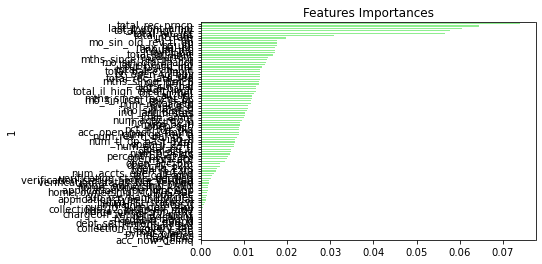

In [23]:
 # Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rfb_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)


### Easy Ensemble Classifier

In [24]:
# Train the Classifier
rfe_model =EasyEnsembleClassifier(n_estimators=500, random_state=78)
rfe_model = rfe_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions_e = rfe_model.predict(X_test_scaled)
 # Calculating the confusion matrix
cm_e = confusion_matrix(y_test, predictions_e)
cm_e_df = pd.DataFrame(
    cm_e, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_e)

In [25]:
# Calculated the balanced accuracy score
# Display the confusion matrix

print("Confusion Matrix")
display(cm_e_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_e))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,13515,3598
Actual 1,36,56


Accuracy Score : 0.7887823307178146
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     17113
           1       0.02      0.61      0.03        92

    accuracy                           0.79     17205
   macro avg       0.51      0.70      0.46     17205
weighted avg       0.99      0.79      0.88     17205



In [130]:
print(classification_report_imbalanced(y_test, predictions_e))

                   pre       rec       spe        f1       geo       iba       sup

          0       1.00      0.79      0.61      0.88      0.69      0.49     17113
          1       0.02      0.61      0.79      0.03      0.69      0.47        92

avg / total       0.99      0.79      0.61      0.88      0.69      0.49     17205



In [118]:
# Print the imbalanced classification report
importances = rfb_model.feature_importances_
importances

array([0.01028084, 0.03077107, 0.01676734, 0.01725047, 0.0197264 ,
       0.00445458, 0.01066357, 0.00912163, 0.00146043, 0.017233  ,
       0.01171212, 0.01359684, 0.01479078, 0.05666139, 0.060524  ,
       0.07386903, 0.05777859, 0.01367504, 0.        , 0.        ,
       0.06445934, 0.00051535, 0.        , 0.        , 0.00315033,
       0.01279071, 0.00568585, 0.00702683, 0.00382622, 0.0078478 ,
       0.01366285, 0.012919  , 0.01369483, 0.00448731, 0.0062632 ,
       0.01763584, 0.01223789, 0.01429996, 0.00837405, 0.00760583,
       0.00947571, 0.00888404, 0.01353652, 0.01378885, 0.01768981,
       0.00013019, 0.        , 0.0153516 , 0.01772646, 0.0119675 ,
       0.0109851 , 0.00598532, 0.01198685, 0.01561249, 0.00362745,
       0.0077206 , 0.00993756, 0.00701133, 0.00915926, 0.0110205 ,
       0.00882582, 0.01164589, 0.00882076, 0.01033025, 0.        ,
       0.        , 0.00072994, 0.0079392 , 0.00889404, 0.00672564,
       0.00141313, 0.        , 0.01507653, 0.01380507, 0.01713

In [119]:
sorted(zip(rfb_model.feature_importances_, X.columns), reverse=True)

[(0.07386902963971798, 'total_rec_prncp'),
 (0.06445934455509018, 'last_pymnt_amnt'),
 (0.06052400159572526, 'total_pymnt_inv'),
 (0.05777859303750801, 'total_rec_int'),
 (0.05666139453891473, 'total_pymnt'),
 (0.030771070732497005, 'int_rate'),
 (0.01972640120527161, 'dti'),
 (0.017726464194883818, 'mo_sin_old_rev_tl_op'),
 (0.017689810960172463, 'bc_util'),
 (0.017635841122037428, 'max_bal_bc'),
 (0.01725047112022555, 'annual_inc'),
 (0.017232996738917726, 'revol_bal'),
 (0.017137416313661533, 'total_bc_limit'),
 (0.01676733899053711, 'installment'),
 (0.015612492787435034, 'mths_since_recent_inq'),
 (0.01535159793263124, 'mo_sin_old_il_acct'),
 (0.015076531469989137, 'tot_hi_cred_lim'),
 (0.01479078324192959, 'out_prncp_inv'),
 (0.014299962106055752, 'total_rev_hi_lim'),
 (0.013805071352902964, 'total_bal_ex_mort'),
 (0.013788852880833782, 'bc_open_to_buy'),
 (0.013694827710895804, 'il_util'),
 (0.013675036939026722, 'total_rec_late_fee'),
 (0.013662849473306227, 'mths_since_rcnt_il

<AxesSubplot:title={'center':'Features Importances'}, ylabel='1'>

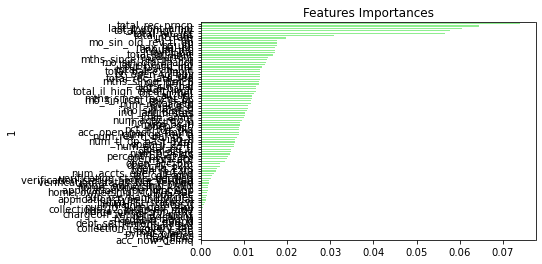

In [134]:
 # Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rfb_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)


### Final Questions

1. Which model had the best balanced accuracy score?

    The balanced Random Forest Classifier produces a higher accuracy score. 

2. Which model had the best recall score?

     The balanced Random Forest Classifier produces a higher recall score.

3. Which model had the best geometric mean score?

    Both approaches produced the same geometric mean score. 

4. What are the top three features?

    For the balanced Random Forest classifier the top three features are: Total Received Principal --'total_rec_prncp', Last Payment Amount -- 'last_pymnt_amnt', and Total payment invoiced -- 'total_pymnt_inv'.
    For the Ensempled Learners, the top three features are the same: Total Received Principal --'total_rec_prncp', Last Payment Amount -- 'last_pymnt_amnt', and Total payment invoiced -- 'total_pymnt_inv'.
    
    This  shows that a borrowers' risk is highly dependent on whether they made the last payment, based on this data set. 